In [18]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from gluonts.dataset.split import split
from gluonts.dataset.common import (
    MetaData,
    TrainDatasets,
    FileDataset,
)
plt.style.use('seaborn')

/tmp/ipykernel_17538/3732702600.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [6]:
def get_custom_dataset(
    jsonl_path: Path,
    freq: str,
    prediction_length: int,
    split_offset: int = None,
):
    """Creates a custom GluonTS dataset from a JSONLines file and
    give parameters.

    Parameters
    ----------
    jsonl_path
        Path to a JSONLines file with time series
    freq
        Frequency in pandas format
        (e.g., `H` for hourly, `D` for daily)
    prediction_length
        Prediction length
    split_offset, optional
        Offset to split data into train and test sets, by default None

    Returns
    -------
        A gluonts dataset
    """
    if split_offset is None:
        split_offset = -prediction_length

    metadata = MetaData(freq=freq, prediction_length=prediction_length)
    test_ts = FileDataset(jsonl_path, freq)
    train_ts, _ = split(test_ts, offset=split_offset)
    dataset = TrainDatasets(metadata=metadata, train=train_ts, test=test_ts)
    return dataset

In [9]:
dataset = get_custom_dataset('datasets/all_stocks_dataset.jsonl', freq='D', prediction_length=30)

In [10]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

# Initialize the DeepAR estimator
deepar_estimator = DeepAREstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=100,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
deepar_predictor = deepar_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:06<00:00, 14.50it/s, epoch=100/100, avg_epoch_loss=-3.36]


In [11]:
from gluonts.mx.model.transformer import TransformerEstimator

# Initialize the Transformer estimator
transformer_estimator = TransformerEstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=100,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
transformer_predictor = transformer_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:04<00:00, 22.87it/s, epoch=100/100, avg_epoch_loss=-3.04]


In [21]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

def evaluate_model(predictor, test_data):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(tss, forecasts, num_series=len(test_data))

    for i, (ts_entry, forecast_entry) in enumerate(zip(tss, forecasts)):
        # Plot and save each time series and forecast comparison
        plt.figure(figsize=(10, 5))
        plt.plot(ts_entry[-150:].to_timestamp(), label='Actual')  # Adjust the slicing according to your data
        forecast_entry.plot(color='crimson', label='Forecast')
        plt.legend()
        plt.title(f'Forecast vs Actuals for Series {i}')
        # plt.savefig(os.path.join(output_dir, f'forecast_plot_{i}.png'))  # Save the plot as a PNG file
        plt.plot()

    return agg_metrics, item_metrics


Running evaluation: 100%|██████████| 12/12 [00:00<00:00, 92.17it/s]


DeepAR Evaluation Metrics: {'MSE': 0.00021161243267771272, 'abs_error': 3.8946287482976913, 'abs_target_sum': 3.445371814072132, 'abs_target_mean': 0.009570477261311479, 'seasonal_error': 0.023323918263723164, 'MASE': 0.48591816237889734, 'MAPE': 1.993284045325385, 'sMAPE': 1.4389734692043727, 'MSIS': 3.814901733517436, 'QuantileLoss[0.1]': 1.9380382559727882, 'Coverage[0.1]': 0.09166666666666666, 'QuantileLoss[0.2]': 2.8316796794300902, 'Coverage[0.2]': 0.18611111111111112, 'QuantileLoss[0.3]': 3.413766737794503, 'Coverage[0.3]': 0.25, 'QuantileLoss[0.4]': 3.745788882882334, 'Coverage[0.4]': 0.3666666666666667, 'QuantileLoss[0.5]': 3.894628847381682, 'Coverage[0.5]': 0.48333333333333334, 'QuantileLoss[0.6]': 3.841821137489751, 'Coverage[0.6]': 0.5694444444444443, 'QuantileLoss[0.7]': 3.516431141033536, 'Coverage[0.7]': 0.6611111111111111, 'QuantileLoss[0.8]': 2.810788392424001, 'Coverage[0.8]': 0.7583333333333332, 'QuantileLoss[0.9]': 1.8860391116701065, 'Coverage[0.9]': 0.88611111111

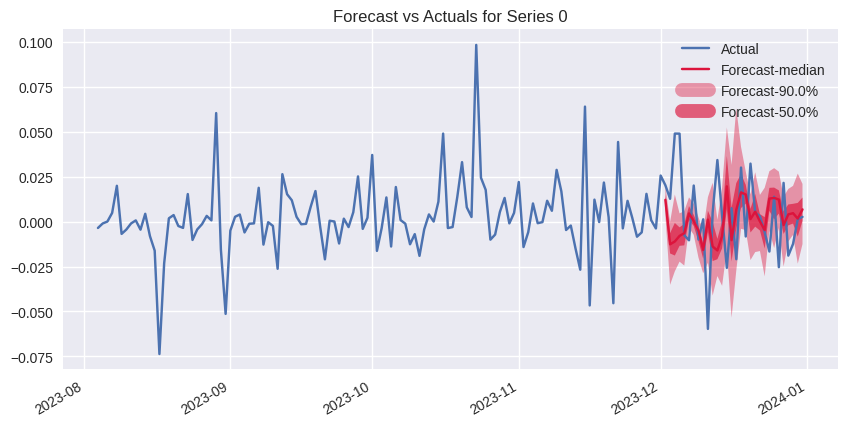

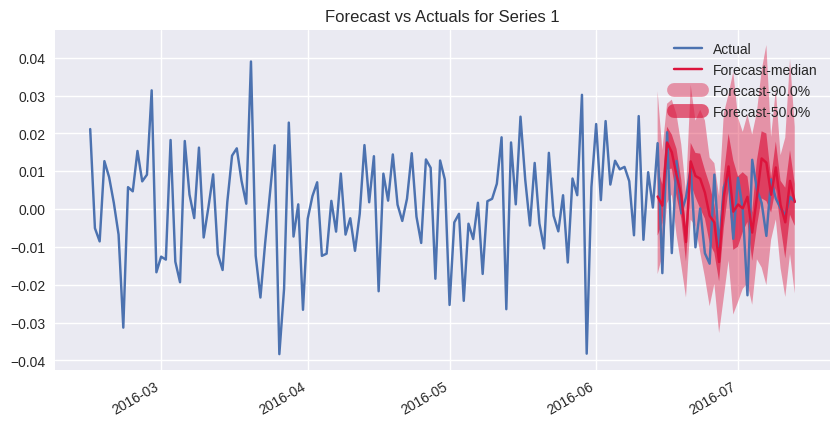

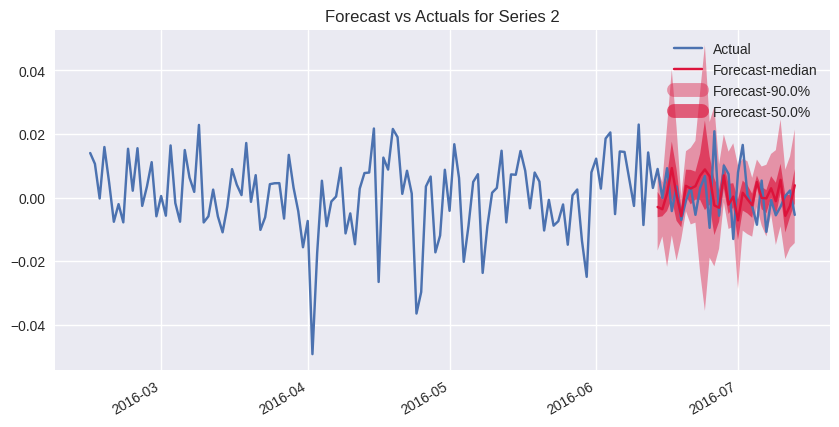

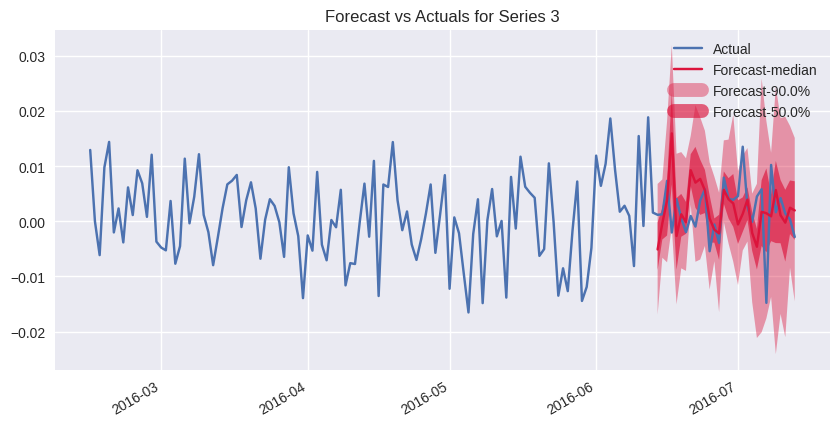

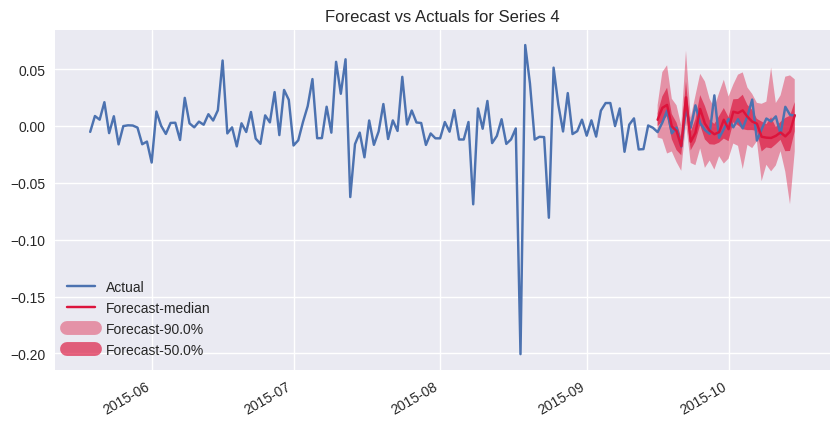

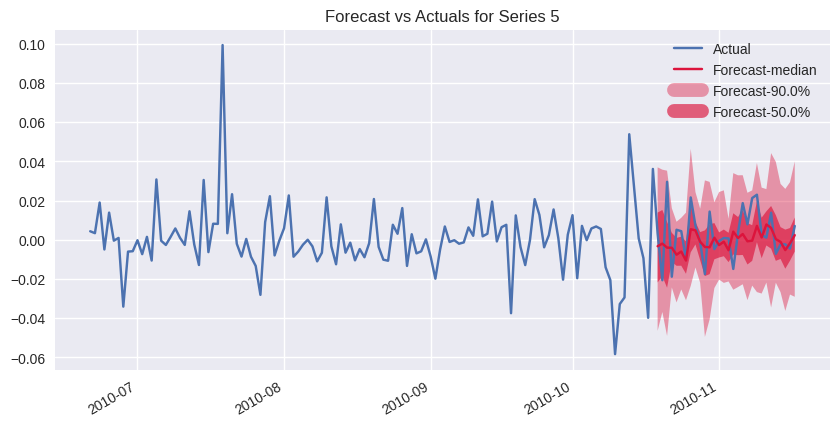

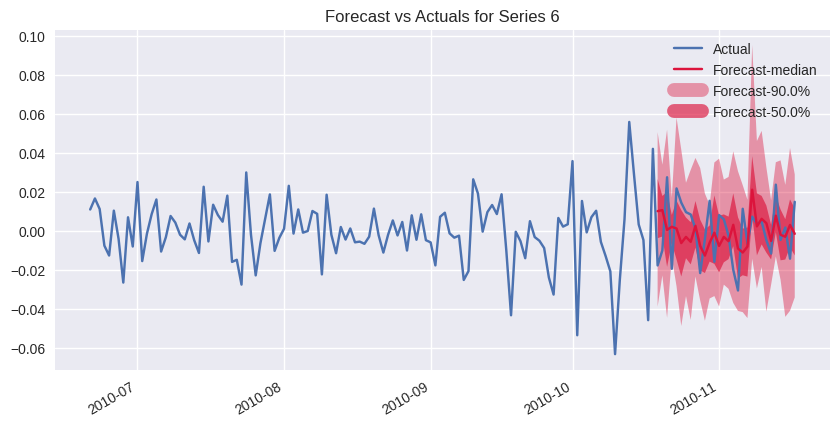

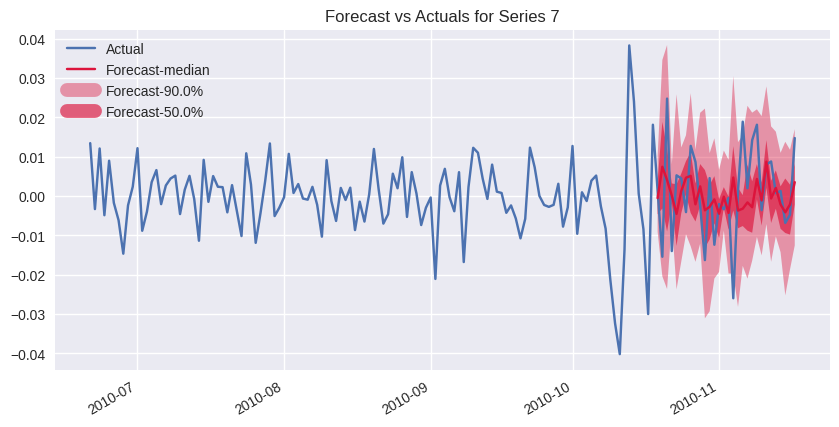

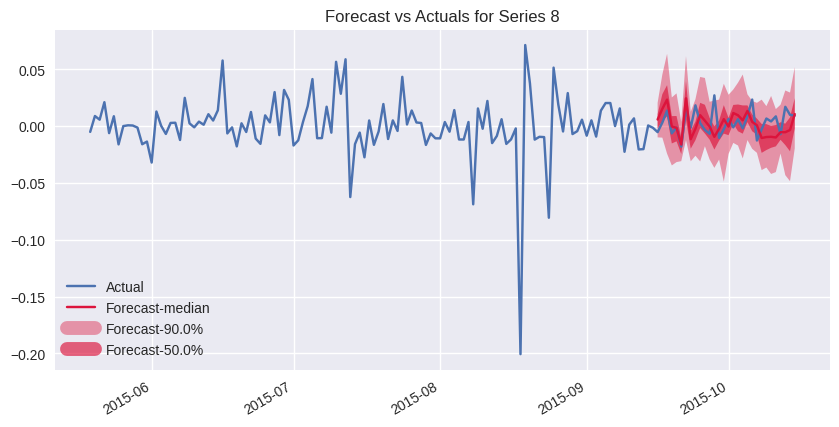

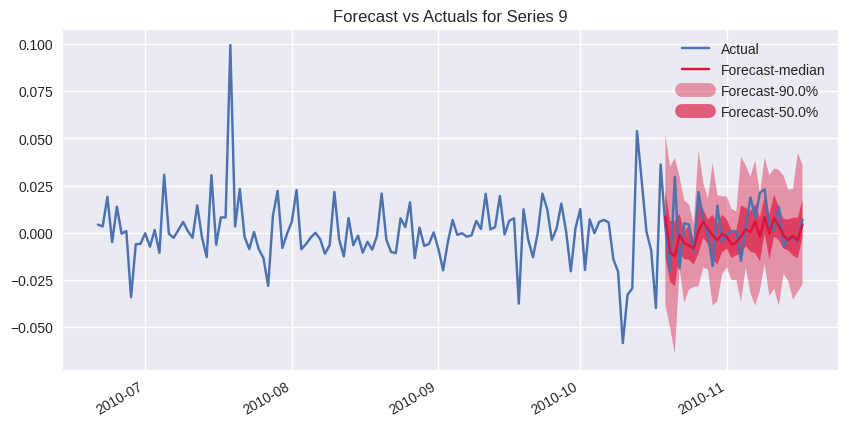

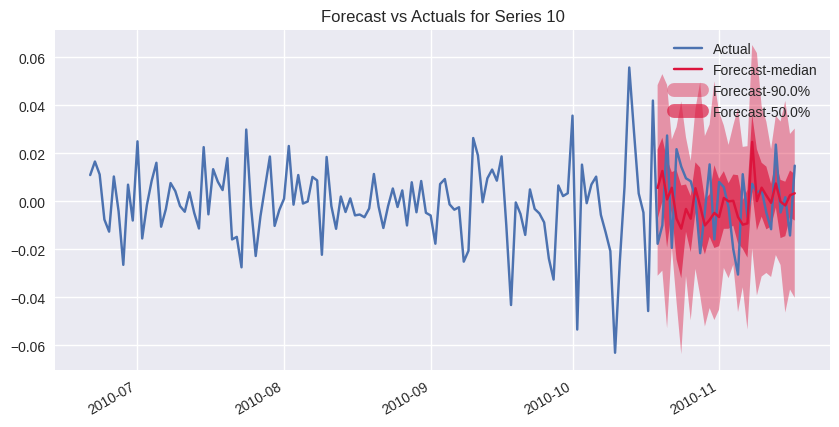

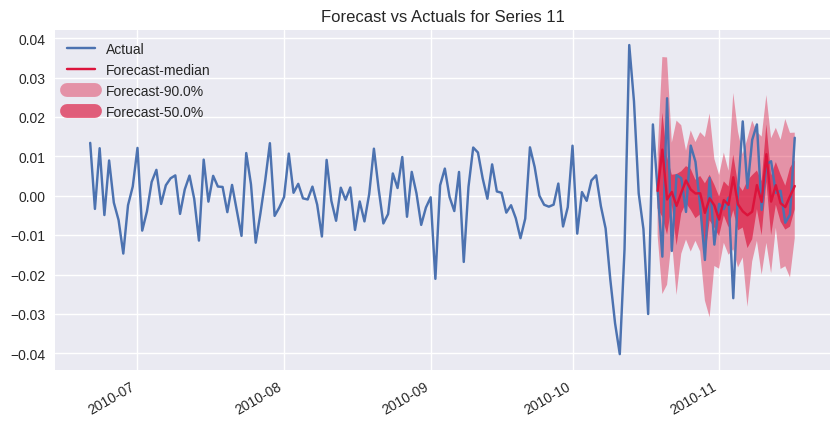

In [22]:
deepar_metrics, _ = evaluate_model(deepar_predictor, dataset.test)
print("DeepAR Evaluation Metrics:", deepar_metrics)


Running evaluation: 100%|██████████| 12/12 [00:00<00:00, 86.90it/s]


Transformer Evaluation Metrics: {'MSE': 0.00015986034801850716, 'abs_error': 3.326120361685753, 'abs_target_sum': 3.445371814072132, 'abs_target_mean': 0.009570477261311479, 'seasonal_error': 0.023323918263723164, 'MASE': 0.4272301109332976, 'MAPE': 2.2346127880944144, 'sMAPE': 1.3539303037855361, 'MSIS': 3.191350340607666, 'QuantileLoss[0.1]': 1.630646236194298, 'Coverage[0.1]': 0.06111111111111111, 'QuantileLoss[0.2]': 2.520683778263628, 'Coverage[0.2]': 0.15, 'QuantileLoss[0.3]': 3.052597024198621, 'Coverage[0.3]': 0.2388888888888889, 'QuantileLoss[0.4]': 3.3102809797273953, 'Coverage[0.4]': 0.3138888888888889, 'QuantileLoss[0.5]': 3.326120393408928, 'Coverage[0.5]': 0.4305555555555555, 'QuantileLoss[0.6]': 3.2029009810881686, 'Coverage[0.6]': 0.5638888888888888, 'QuantileLoss[0.7]': 2.9620192559086718, 'Coverage[0.7]': 0.6833333333333335, 'QuantileLoss[0.8]': 2.490865693241358, 'Coverage[0.8]': 0.7944444444444446, 'QuantileLoss[0.9]': 1.632099765294697, 'Coverage[0.9]': 0.897222222

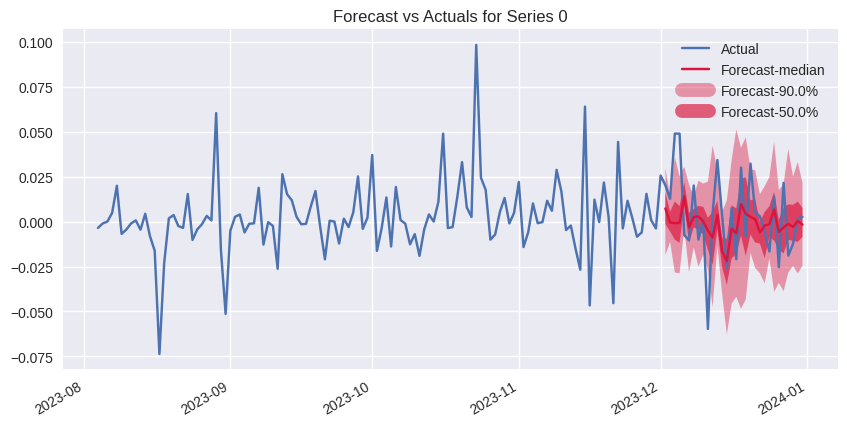

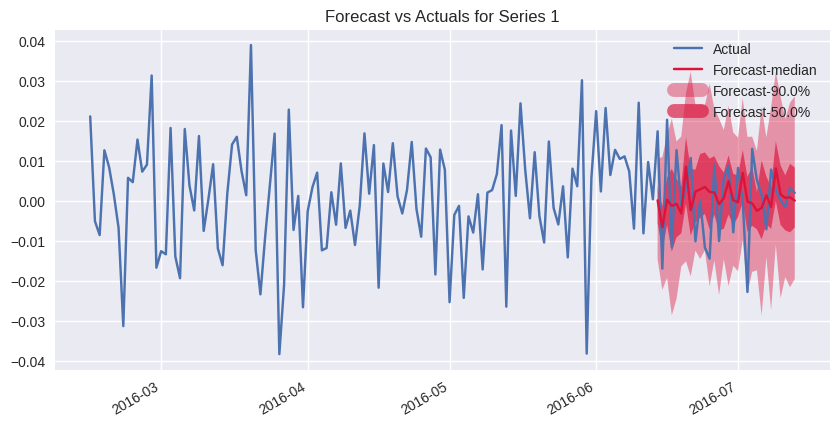

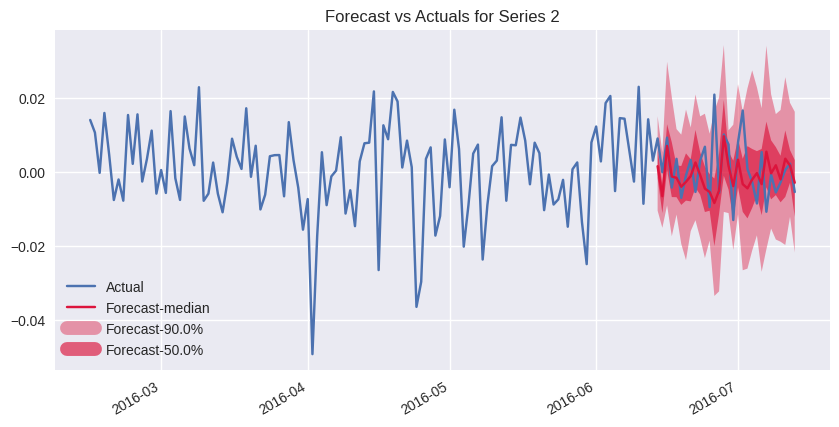

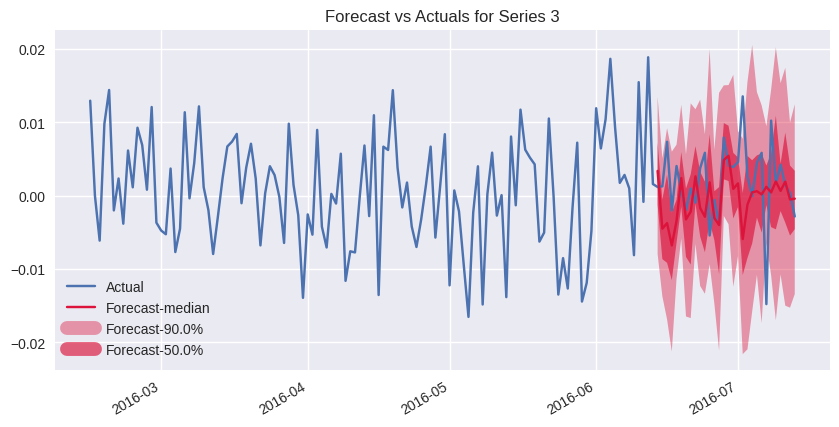

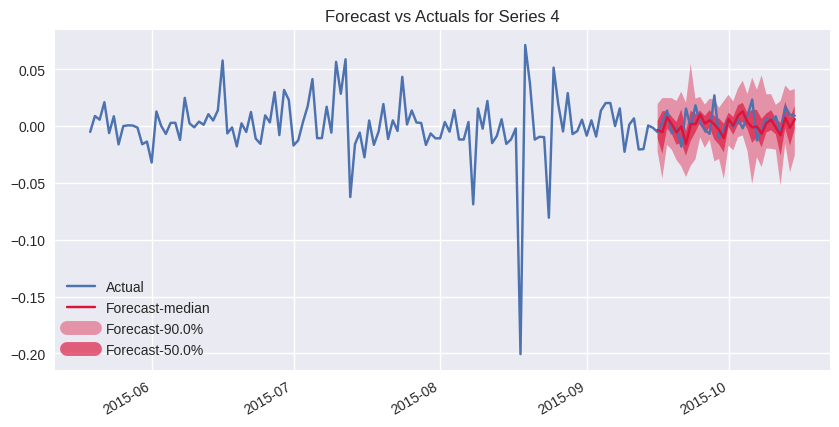

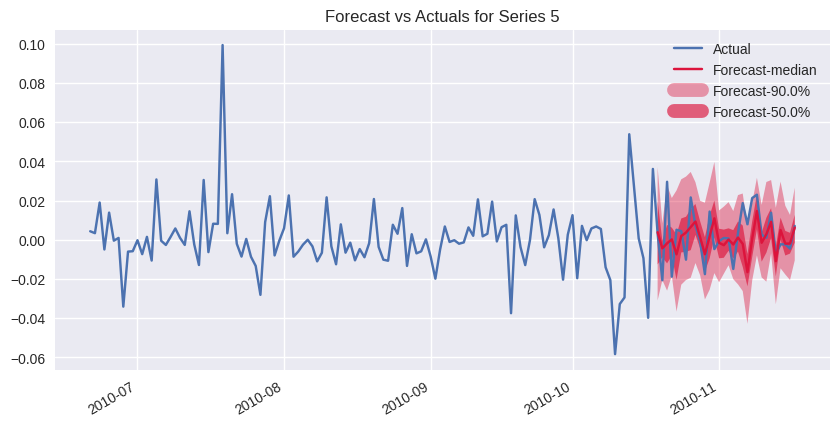

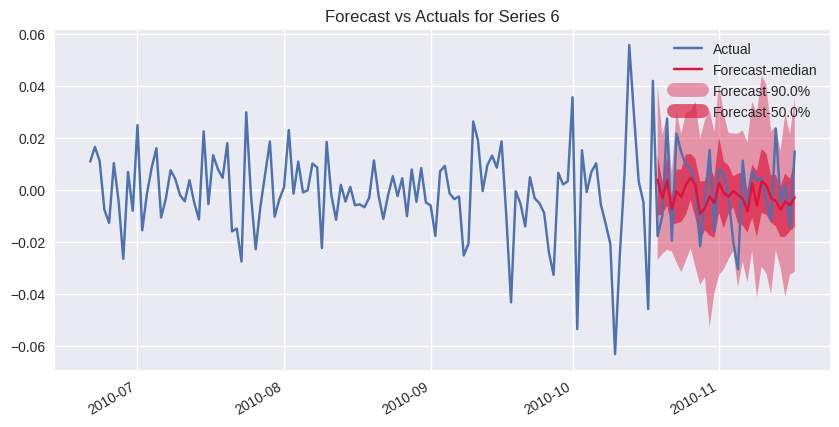

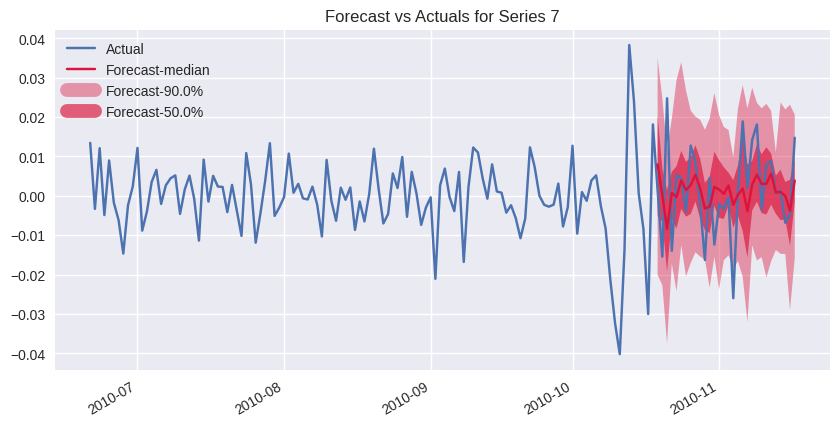

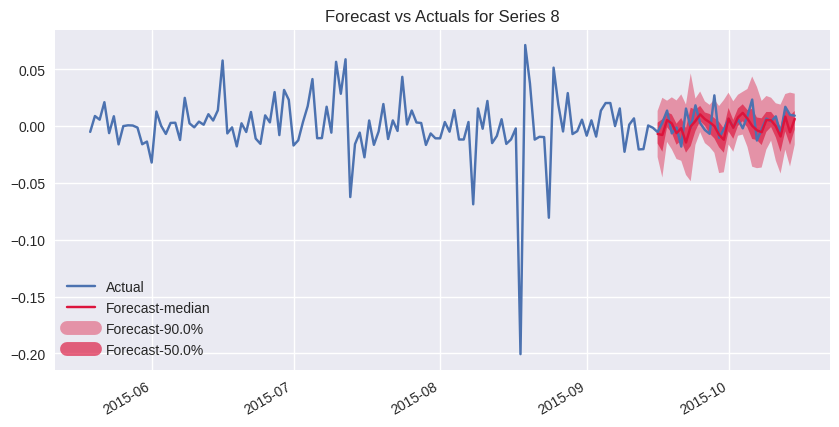

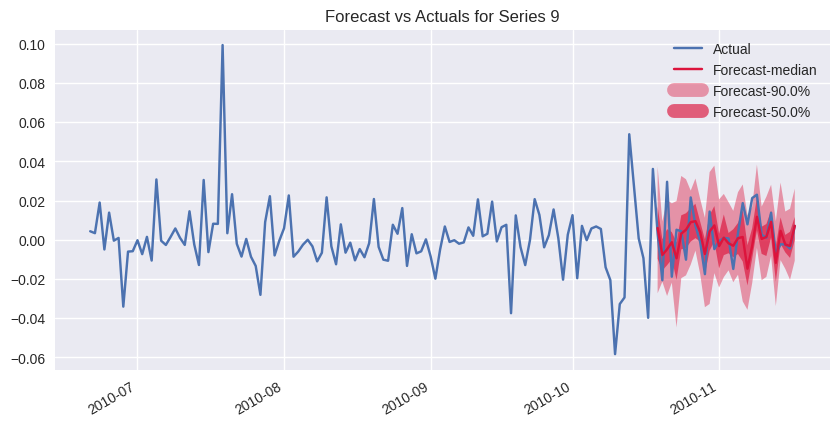

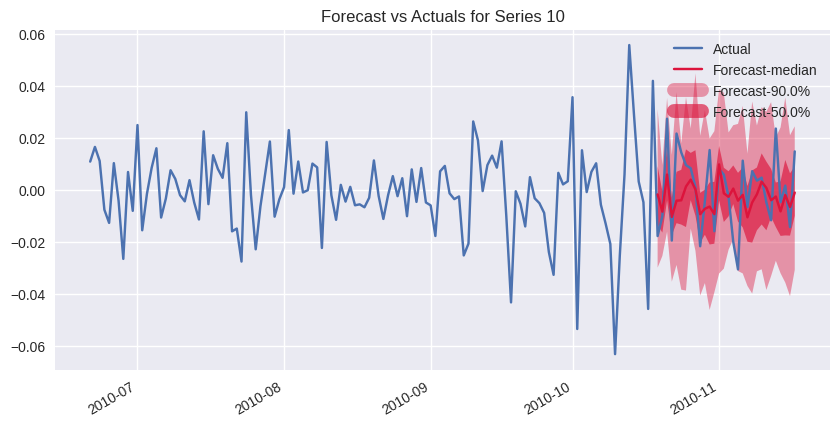

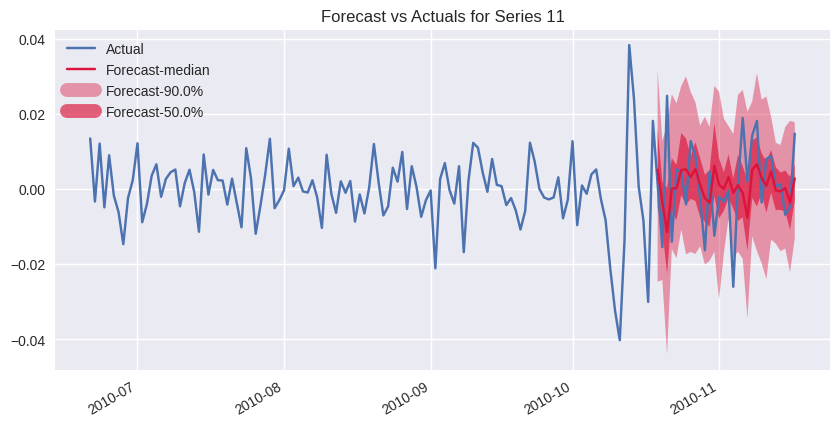

In [23]:
transformer_metrics, _ = evaluate_model(transformer_predictor, dataset.test)
print("Transformer Evaluation Metrics:", transformer_metrics)
